In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import glob
from tqdm import tqdm
import pickle
import torch
import cv2
from skeleton import skeleton
from matplotlib.animation import FFMpegWriter
G, color_edge = skeleton()

In [39]:
np.where(5==np.array([5,6]))[0][0]

0

In [56]:
def video_to_imgs(vid_path):
    '''Convert video to a list of images'''
    
    cap = cv2.VideoCapture(vid_path)         
    imgs = []            
    while True:
        flag, frame = cap.read()
        if flag:                            
            imgs.append(frame)       
        else:
            break        
    
    return imgs

                
def plot_skeleton(x, y, ids, color_edge,  ax=None):
           
    for i, j in enumerate(G.edges()): 
        if (j[0] in ids) & (j[1] in ids):
            u = np.where(j[0]==np.array(ids))[0][0]
            v = np.where(j[1]==np.array(ids))[0][0]
            
            x_coord = np.array((x[u], x[v]))
            y_coord = np.array((y[u], y[v]))
            if ax is not None:
                ax.plot(x_coord, y_coord, c=color_edge[j[0]], linewidth = 4)
            else:
                plt.plot(x_coord, y_coord, c=color_edge[j[0]], linewidth = 4)

In [64]:
home_dir = '/data/LiftFly3D/optobot/102906_s1a5_p6-0/'

experiments = ['vid_p6-0_off1_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_off2_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5',
               'vid_p6-0_off2_fly1_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5']
joints = ['RFbodyCoxa', 'RFfemurTibia', 'RFtibiaTarsus', 'RFclaw',
          'RMbodyCoxa', 'RMfemurTibia', 'RMtibiaTarsus', 'RMclaw',
          'RHbodyCoxa', 'RHfemurTibia', 'RHtibiaTarsus', 'RHclaw',
          'LFbodyCoxa', 'LFfemurTibia', 'LFtibiaTarsus', 'LFclaw', 
          'LMbodyCoxa', 'LMfemurTibia', 'LMtibiaTarsus', 'LMclaw',
          'LHbodyCoxa', 'LHfemurTibia', 'LHtibiaTarsus', 'LHclaw']
ids = [1, 2, 3, 4,  6, 7, 8, 9,  11, 12, 13, 14,  16, 17, 18, 19,  21, 22, 23, 24,  26, 27, 28, 29]

prism_data = '/data/LiftFly3D/prism/data_oriented/training_data/191125_PR_Fly1_001_prism.pkl'

Preprocess data

In [65]:
for i in tqdm(range(len(experiments))):
    data = pd.read_hdf(home_dir + experiments[i]) #load data
    data = data.droplevel('scorer',axis=1) #drop scorer column label

    #convert & save to DF3D format
    data_np = data.loc[:,(joints,['x','y'])].to_numpy()
    
    #rotate flies pointing left
    theta = np.radians(90)
    cos, sin = np.cos(theta), np.sin(theta)
    R = np.array(((cos, -sin), (sin, cos)))
    
    data_np = data_np.reshape(-1,2)
    data_np = np.matmul(data_np - 68,R) + 68
    data_np = data_np.reshape(-1,2*len(joints))
    data_np = np.stack((data_np[:,::2], data_np[:,1::2]), axis=2)
    
    poses = {'points2d': data_np}
    
    #save
    pickle.dump(poses,open(home_dir + experiments[i][:-3] + '.pkl', 'wb'))

100%|██████████| 3/3 [00:00<00:00, 114.76it/s]


In [66]:
data_np.shape

(799, 24, 2)

Overlay DLC predictions with video

In [67]:
experiments[1]

'vid_p6-0_off2_fly0_DLC_resnet50_dlcTrackingAug6shuffle1_1030000.h5'

(-0.5, 137.5, 137.5, -0.5)

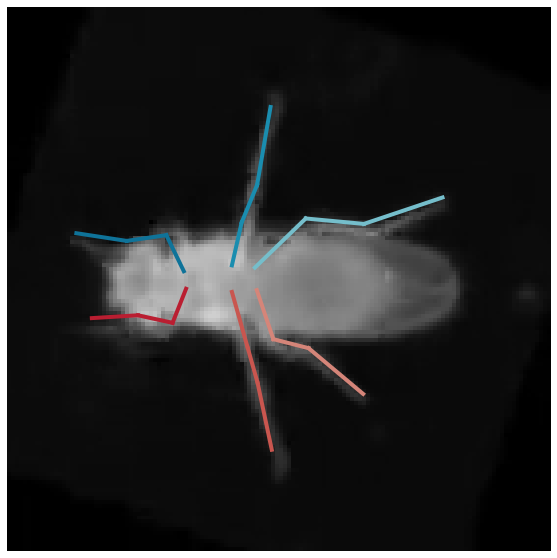

In [68]:
imgs = video_to_imgs(home_dir + '_'.join(experiments[1].split('_')[:4] + ['.mp4']))
data = pickle.load(open(home_dir + experiments[1][:-3] + '.pkl','rb'))
poses = data['points2d']

f= plt.figure(figsize=(10,10))
im_rot = ndimage.rotate(imgs[200],90)
plt.imshow(im_rot,cmap='gray', vmin=0, vmax=255)
plot_skeleton(poses[200,:,0],poses[200,:,1], ids, color_edge)
plt.axis('off')

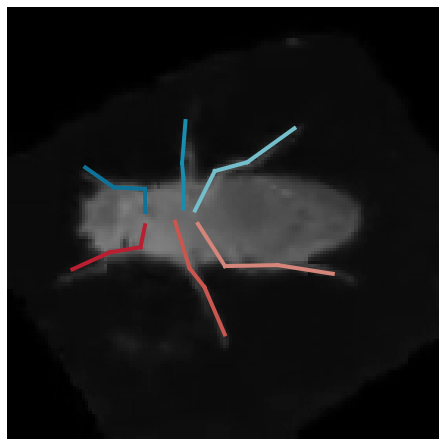

In [72]:
imgs = video_to_imgs(home_dir + '_'.join(experiments[1].split('_')[:4] + ['.mp4']))
data = pickle.load(open(home_dir + experiments[1][:-3] + '.pkl','rb'))
poses = data['points2d']

#full image
fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
            
metadata = dict(title='LiftFly3D prediction', artist='Nely',comment='Watch this!')
writer = FFMpegWriter(fps=15, metadata=metadata)
with writer.saving(fig, "DLC_prediction.mp4", 100):
    for i in range(799):
        pos_pred, pos_tar = [], []   
        plt.cla()
        
        im_rot = ndimage.rotate(imgs[i],90)
        plt.imshow(im_rot,cmap='gray', vmin=0, vmax=255)
                 
        plot_skeleton(poses[i,:,0],poses[i,:,1], ids, color_edge)
        
        plt.axis('off')
        writer.grab_frame() 

Check data after preprocessing

/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


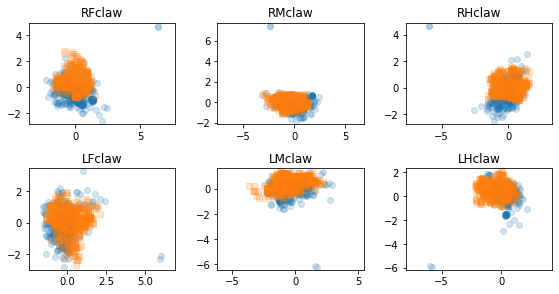

In [71]:
def unNormalizeData(data, data_mean, data_std):
    """
    Un-normalizes a matrix whose mean has been substracted and that has been divided by
    standard deviation. Some dimensions might also be missing
    """
    data *= data_std
    data += data_mean
    
    return data

tint = [0,700]
times = np.arange(tint[0],tint[1])

prism_dir = '/data/LiftFly3D/optobot/network/'
optobot_dir = '/data/LiftFly3D/optobot/102906_s1a5_p6-0/'

poses_optobot = torch.load(optobot_dir + 'test_2d.pth.tar')
poses_prism = torch.load(prism_dir + 'train_2d.pth.tar')

poses_optobot = np.vstack(poses_optobot.values())
poses_prism = np.vstack(poses_prism.values())

targets_1d = torch.load(optobot_dir + '/stat_2d.pth.tar')['targets_1d'] 
#targets_2d = torch.load(prism_dir + '/stat_2d.pth.tar')['targets_2d']   
#mean = torch.load(optobot_dir + '/stat_2d.pth.tar')['mean']
#std = torch.load(optobot_dir + '/stat_2d.pth.tar')['std']
#poses_optobot = unNormalizeData(poses_optobot, mean[targets_2d], std[targets_2d])
#poses_prism = unNormalizeData(poses_prism, mean[targets_2d], std[targets_2d])

poses_optobot = np.stack((poses_optobot[:,::2], poses_optobot[:,1::2]), axis=2)
poses_prism = np.stack((poses_prism[:,::2], poses_prism[:,1::2]), axis=2)

fig = plt.figure(figsize=([8,8])) 

joint_id = [2, 5, 8, 11, 14, 17] #legtips
#joint_id = [1, 2, 4,5, 7,8, 10,11, 13,14, 16,17]
for i, k in enumerate(joint_id):
    fig.add_subplot(4,3,i+1)
    plt.title(joints[targets_1d[k]])
    
    #for i in [2, 5, 8, 11, 14, 17]:#[4,9,14,19,24,29]:
    plt.plot(poses_prism[times,k,0], poses_prism[times,k,1],'o',alpha=0.2)
    
    #for i in :#[3,7,11,15,19,23]:
    
    plt.plot(poses_optobot[times,k,0], poses_optobot[times,k,1],'s',alpha=0.2)
    plt.axis('equal')
    
plt.tight_layout()
#plt.savefig('pose_distributions.png')